# Preparing the DC2 Run 1.1p Data

**Owner:** Phil Marshall (@drphilmarshall)

**Last Run:** 2018-10-24 (by @drphilmarshall)

**Goals:** Use the DC2 Run 1.1p truth catalog, and DRP Object table, to construct a design matrix `X` (from the truth table) and corresponding response variables `y` (from the DRP Object table).

**Notes:** This notebook was made by adapting the following notebooks:
* Scott Daniel's DC2 Tutorial [`truth_gcr_intro.ipynb`](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/truth_gcr_intro.ipynb)
* Yao-Yuan Mao's DC2 Tutorial [`matching_fof.ipynb`](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/matching_fof.ipynb)

To run this notebook, follow the instructions to setup Jupyter-dev at NERSC: https://confluence.slac.stanford.edu/x/1_ubDQ

## Setup

In [1]:
# import packages and methods that will be used in this notebook

import healpy
import numpy as np
import pandas as pd
import GCRCatalogs
from astropy.coordinates import SkyCoord
import FoFCatalogMatching

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Loading the Input Truth

In [2]:
# truth_catalog = GCRCatalogs.load_catalog('dc2_truth_run1.1_static')
truth_catalog = GCRCatalogs.load_catalog('dc2_truth_run1.1', {'md5': None})

You can list the quantities contained in the catalog using the same API as any other GCR-based catalog.

In [3]:
all_true = truth_catalog.list_all_quantities(include_native=True)
all_true

['mag_true_y',
 'ra',
 'r',
 'z',
 'mag_true_z',
 'mag_true_i',
 'y',
 'u',
 'healpix_2048',
 'mag_true_r',
 'redshift',
 'mag_true_u',
 'g',
 'mag_true_g',
 'object_id',
 'dec',
 'star',
 'sprinkled',
 'agn',
 'i']

The `get_quantity_info` method will give you access to descriptions of all of the native quantities in the catalog.  Note that the quantities `ugrizy` map directly to `mag_true_[ugrizy]'.

In [4]:
for qty in all_true:
    info_dict = truth_catalog.get_quantity_info(qty)
    print(qty,info_dict)

mag_true_y None
ra {'description': 'in degrees'}
r {'description': 'observed lsst r magnitude; no dust extinction at all'}
z {'description': 'observed lsst z magnitude; no dust extinction at all'}
mag_true_z None
mag_true_i None
y {'description': 'observed lsst y magnitude; no dust extinction at all'}
u {'description': 'observed lsst u magnitude; no dust extinction at all'}
healpix_2048 {'description': 'healpixel containing the object (nside=2048; nested)'}
mag_true_r None
redshift {'description': 'cosmological only'}
mag_true_u None
g {'description': 'observed lsst g magnitude; no dust extinction at all'}
mag_true_g None
object_id {'description': 'an int uniquely identifying objects (can collide between stars, galaxies, and sprinkled objects)'}
dec {'description': 'in degrees'}
star {'description': 'an int; ==1 if a star; ==0 if not'}
sprinkled {'description': 'an int; ==1 if object added by the sprinkler; ==0 if not'}
agn {'description': 'an int; ==1 if galaxy has an AGN; ==0 if not'

Let's define a small photometric and spatial subset to work with, just for demo purposes.

In [5]:
some_true = ['u',
             'g',
             'r',
             'i',
             'z',
             'y',
             'ra',
             'dec',
             'star',
             'object_id',
             'redshift',
             'healpix_2048'
]

print(len(some_true))

12


We'll want to keep our training and test set small while developing, but then increase its size later. A good option for selecting a subset of objects is to filter by sky position, either relative to some reference point, or using the healpixellation.

In the cells below, we will query the catalog for all of the bright stars and galaxies in a 0.2 degree disc centered on `RA=55.8`, `Dec=-28.8`.

In the next cell, we will define some methods (`filter_on_healpix` and `filter_on_dist`) needed to make that selection.  These methods will be passed into the catalog's `get_quantities` method with the `filters` kwarg.  The methods should accept numpy arrays and return a numpy array of booleans indicating whether or not each object in the input arrays passed the test.

We will use `healpy`'s `query_disc` method to find which healpixels overlap our region of interest.

In [6]:
center_ra = 55.8
center_dec = -28.8
radius = 0.2

ra_min, ra_max = center_ra - radius, center_ra + radius
dec_min, dec_max = center_dec - radius, center_dec + radius

center_ra_rad = np.radians(center_ra)
center_dec_rad = np.radians(center_dec)

center_vec = np.array([np.cos(center_dec_rad)*np.cos(center_ra_rad),
                       np.cos(center_dec_rad)*np.sin(center_ra_rad),
                       np.sin(center_dec_rad)])

list_of_healpix = healpy.query_disc(2048, center_vec, np.radians(radius), nest=True, inclusive=True)

def filter_on_healpix(hp):
    return np.array([hh in list_of_healpix for hh in hp])

def angularSeparation(ra, dec, center_ra, center_dec):
    return SkyCoord(ra, dec, unit='deg').separation(SkyCoord(center_ra, center_dec, unit='deg')).deg

def filter_on_dist(ra, dec):
    return angularSeparation(ra, dec, center_ra, center_dec) < radius

coord_filters = [
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
]

Now we let's query the catalog for all objects in the region of interest with magnitude `r<27.0`.  This query functions like any other GRC-based catalog query with one exception.  The truth catalog is ultimately stored as a sqlite database.  This means that all `native_filters` (filters applied directly to the catalog's native quantities), should be phrased as strings which could be inserted into an SQL `WHERE` clause.  Because the `native_filters` are applied when the quantities loaded into memory (as opposed to `filters`, which are applied after the quantities have been loaded), we want these to be as restrictive as possible so as to limit the memory consumption of the loaded catalog.  The sqlite databases are indexed on `star`, `agn`, `sprinkled`, `healpix_2048` and `object_id`.

**Note:** We are aware that `nside==2048` healpixels may be too fine a resolution to helpfully limit the catalog query.  We are open to the idea of using a coarser resolution in future truth catalogs.

After the coarse spatial limits applied by the `native_filter` on `healpix_2048`, we use the `filter_on_healpix` and `filter_on_dist` methods to actually get sources in our region of interest.

In [7]:
true_objects = truth_catalog.get_quantities(some_true,
                                            native_filters=['r<27.0',
                                                            'healpix_2048<=%d' % list_of_healpix.max(),
                                                            'healpix_2048>=%d' % list_of_healpix.min()],
                                            filters=[(filter_on_healpix, 'healpix_2048')]+coord_filters)  
                                            
#                                            filters=[(filter_on_healpix, 'healpix_2048'),
#                                                     (filter_on_dist, 'ra', 'dec')])

In [8]:
print(len(true_objects['ra']))

33442


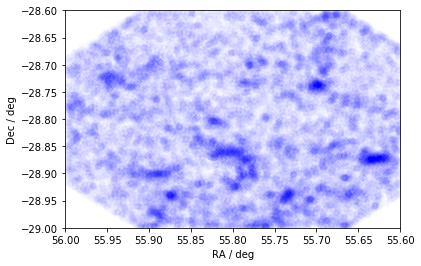

In [9]:
plt.scatter(true_objects['ra'], true_objects['dec'], alpha=0.01, color="blue")
plt.xlim(ra_max, ra_min)
plt.ylim(dec_min, dec_max)
plt.xlabel('RA / deg')
plt.ylabel('Dec / deg');

We could also perform a similar spatial query for objects which were not added by the sprinkler (`sprinkled==0`) with magnitudes `r<27`.

> Nb: "the sprinkler" is a piece of code used to add an extra population of AGN and supernovae into the Utral Deep Drilling Field of DC2.  Objects added by the sprinkler will have no counterpart in the underlying protoDC2 extragalactic catalog, which is why we have added a `sprinkled` flag to the catalog.

In [10]:
unsprinkled_true_objects = truth_catalog.get_quantities(some_true,
                                                        native_filters=['sprinkled==0',
                                                                           'r<27.0',
                                                                           'healpix_2048<=%d' % list_of_healpix.max(),
                                                                           'healpix_2048>=%d' % list_of_healpix.min()],
                                                        filters=[(filter_on_healpix, 'healpix_2048'),
                                                                 (filter_on_dist, 'ra', 'dec')])

In [11]:
print(len(unsprinkled_true_objects['ra']))

32394


Only a handful of objects in this 0.2 deg radius circular aperture have been sprinkled.

## Loading the Observed LSST Objects

Now we need to load in a DRP Object table, so that we can (later) match its contents (spatially) to the input truth objects. We'll do this for just a single tract, no. 4850.

In [45]:
%%time
observed_catalog = GCRCatalogs.load_catalog('dc2_coadd_run1.1p_tract4850')

CPU times: user 2 s, sys: 286 ms, total: 2.28 s
Wall time: 2.54 s


In [46]:
"""
# The full catalog takes 10-20 times longer to load:
%%time
observed_catalog = GCRCatalogs.load_catalog('dc2_coadd_run1.1p')
"""

CPU times: user 8.18 s, sys: 514 ms, total: 8.7 s
Wall time: 55.3 s


In [13]:
all_observed = observed_catalog.list_all_quantities(include_native=True)
len(all_observed)

2573

The object table contains a lot of quantities... Let's define a small photometric and spatial subset to use. We'll make this bigger than the truth subset though, because we expect to be emulating more quantities than we have truth values for, in general.

In [14]:
sorted(all_observed[1300:1320])

['base_Blendedness_flag_noCentroid',
 'base_SdssShape_flag_badCentroid',
 'ext_convolved_ConvolvedFlux_2_6_0_apCorr',
 'ext_convolved_ConvolvedFlux_3_6_0_flag',
 'i_base_CircularApertureFlux_3_0_flag',
 'i_modelfit_DoubleShapeletPsfApprox_1_2',
 'modelfit_CModel_flux',
 'modelfit_CModel_flux_inner',
 'r_base_CircularApertureFlux_12_0_flag_apertureTruncated',
 'r_base_LocalBackground_flux',
 'r_base_SdssShape_flag_unweighted',
 'r_modelfit_CModel_exp_apCorr',
 'r_modelfit_DoubleShapeletPsfApprox_flag_badCentroid',
 'r_slot_ModelFlux_fluxSigma',
 'slot_ApFlux_flag',
 'u_base_SdssShape_y',
 'u_base_TransformedShape_xy',
 'u_modelfit_DoubleShapeletPsfApprox_flag_invalidPointForPsf',
 'u_slot_Centroid_y',
 'y_slot_ModelFlux_flag_region_maxBadPixelFraction']

In [15]:
some_observed = ['mag_u_cModel',
                 'mag_g_cModel',
                 'mag_r_cModel',
                 'mag_i_cModel',
                 'mag_z_cModel',
                 'mag_y_cModel',
                 'ra',
                 'dec',
                 'extendedness',
                 'objectId',
                 'ext_shapeHSM_HsmShapeRegauss_e1',
                 'ext_shapeHSM_HsmShapeRegauss_e2',
                 'ext_shapeHSM_HsmShapeRegauss_sigma',
                 'u_modelfit_CModel_fracDev',
                 'u_modelfit_CModel_flux',
                 'g_modelfit_CModel_fracDev',
                 'g_modelfit_CModel_flux',
                 'r_modelfit_CModel_fracDev',
                 'r_modelfit_CModel_flux',
                 'i_modelfit_CModel_fracDev',
                 'i_modelfit_CModel_flux',
                 'z_modelfit_CModel_fracDev',
                 'z_modelfit_CModel_flux',
                 'y_modelfit_CModel_fracDev',
                 'y_modelfit_CModel_flux'
]

print(len(some_observed))

25


Let's choose a small RA and Dec range to do the matching so that it won't take too long! Let's also define a magnitude cut.

> Nb. Recall that we selected objects in the truth catalog using the following circular aperture:
```
center_ra = 54.6
center_dec = -28.0
radius = 0.2
```

In [16]:
mag_filters = [
    (np.isfinite, 'mag_r_cModel'),
    'mag_r_cModel < 27.0',
]

# For some reason this filter doesn't work, here.
# coord_filters = [
#     (filter_on_dist, 'ra', 'dec')
# ]

coord_filters = [
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
]

In [17]:
# Load some observed quantities, using both of the filters we just defined. 
observed_objects = observed_catalog.get_quantities(some_observed, 
                                                filters=(mag_filters + coord_filters))

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCRCatalogs/dc2_object.py:300: RuntimeWarning: divide by zero encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCRCatalogs/dc2_object.py:300: RuntimeWarning: invalid value encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,


In [18]:
print(len(observed_objects['ra']))

30870


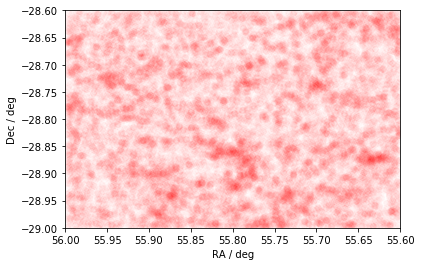

In [19]:
plt.scatter(observed_objects['ra'], observed_objects['dec'], alpha=0.01, color="red")
plt.xlim(ra_max, ra_min)
plt.ylim(dec_min, dec_max)
plt.xlabel('RA / deg')
plt.ylabel('Dec / deg');

## Matching the True and Observed Objects

We now have an array of observed object measurements, and an array of true object parameters: next we need to match them up, by position on the sky. 

`FoFCatalogMatching.match` takes a dictionary of catalogs to match, a friends-of-friends linking length. Because our "catalog" is not an astropy table or pandas dataframe, `len(truth_coord)` won't give the actual length of the table
so we need to specify `catalog_len_getter` so that the code knows how to get the length of the catalog.

In [20]:
results = FoFCatalogMatching.match(
    catalog_dict={'truth': true_objects, 'observed': observed_objects},
    linking_lengths=1.0,
    catalog_len_getter=lambda x: len(x['ra']),
)

Now we want to count the number of truth and coadd objects *for each group*
but instead of looping over groups, we can do this in a smart (and very fast) way. First we need to know which rows are from the truth catalog and which are from the coadd.

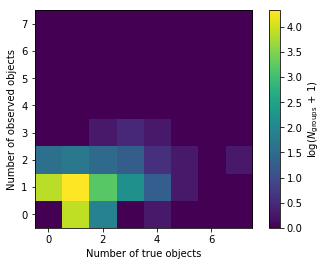

In [21]:
truth_mask = results['catalog_key'] == 'truth'
observed_mask = ~truth_mask

# Then, np.bincount will give up the number of id occurrences 
# (like histogram but with integer input):
n_groups = results['group_id'].max() + 1
n_true = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
n_observed = np.bincount(results['group_id'][observed_mask], minlength=n_groups)

# Now n_true and n_observed are the number of true/observed objects 
# in each group, and we want to make a 2d histogram of (n_true, n_observed). 
n_max = max(n_true.max(), n_observed.max()) + 1
hist_2d = np.bincount(n_observed * n_max + n_true, minlength=n_max*n_max).reshape(n_max, n_max)

plt.imshow(np.log10(hist_2d+1), extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower');
plt.xlabel('Number of true objects');
plt.ylabel('Number of observed objects');
plt.colorbar(label=r'$\log(N_{\rm groups} \, + \, 1)$');

In [22]:
one_to_one = hist_2d[1,1]
total = np.sum(hist_2d)
print(one_to_one, " out of ", total, " FoF groups are 1-to-1 matches.")

21246  out of  38974  FoF groups are 1-to-1 matches.


About half of the FoF groups are 1-to-1 matches. Some of this is due to the mis-orientation between the healpixel we used to speed up the truth catalog pre-selection, but at 27th magnitude, there's also a lot of blending. 

## Formatting into `X` and `y`

Now that we have a set of matched objects, we can reformat them into a design matrix `X` and the corresponding response variables `y`. We'll make these as simple `numpy` arrays.

Let's focus on the objects in the groups that have a 1-to-1 true/observed match. 

In [23]:
one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_true == 1) & (n_observed == 1)))

We need the row indices in the *original* truth/observed 
catalogs for those 1-to-1 groups.

In [24]:
truth_idx = results['row_index'][one_to_one_group_mask & truth_mask]
observed_idx = results['row_index'][one_to_one_group_mask & observed_mask]

Now we can use these indices to pull out the data arrays, and make `pandas` data frames from them.

In [25]:
true_matched = pd.DataFrame(true_objects).iloc[truth_idx].reset_index(drop=True)
observed_matched = pd.DataFrame(observed_objects).iloc[observed_idx].reset_index(drop=True)

We don't want to train and predict the object IDs, so let's drop them:

In [26]:
true_matched.drop(['object_id'], axis=1, inplace=True)
observed_matched.drop(['objectId'], axis=1, inplace=True)

In [27]:
true_matched.head()

,dec,g,healpix_2048,i,r,ra,redshift,star,u,y,z
0,-28.991806,21.220566,36963071,19.143178,19.968730,55.911601,0.000000,True,23.712136,18.571897,18.753682
1,-28.977511,26.089855,36963071,23.680101,24.888352,55.900110,0.000000,True,28.623161,22.898489,23.134674
2,-28.996410,18.707958,36963071,18.405405,18.471620,55.892925,0.000000,True,19.641134,18.413843,18.405028
3,-28.984325,18.958377,36963071,18.054779,18.301951,55.902400,0.000000,True,20.698326,17.906033,17.958187
4,-28.978697,25.940937,36963071,24.704194,25.328733,55.892868,0.669735,False,26.093231,24.565313,24.636821


In [28]:
observed_matched.head()

,dec,ext_shapeHSM_HsmShapeRegauss_e1,ext_shapeHSM_HsmShapeRegauss_e2,ext_shapeHSM_HsmShapeRegauss_sigma,extendedness,g_modelfit_CModel_flux,g_modelfit_CModel_fracDev,i_modelfit_CModel_flux,i_modelfit_CModel_fracDev,mag_g_cModel,...,mag_z_cModel,r_modelfit_CModel_flux,r_modelfit_CModel_fracDev,ra,u_modelfit_CModel_flux,u_modelfit_CModel_fracDev,y_modelfit_CModel_flux,y_modelfit_CModel_fracDev,z_modelfit_CModel_flux,z_modelfit_CModel_fracDev
0,-28.991807,0.142506,-0.200237,0.025201,0.0,217.829131,0.0,1504.482516,1.000000,21.154710,...,18.661071,705.950209,0.81314,55.911601,22.917900,1.0,2504.669981,1.0,2165.565923,1.000000
1,-28.977510,NaN,NaN,NaN,0.0,0.405557,0.0,24.147202,1.000000,27.979869,...,23.144668,8.212308,0.00000,55.900126,-0.350792,-0.0,40.871555,1.0,34.844383,0.000000
2,-28.996411,0.081299,-0.054256,3.369945,0.0,1975.915976,0.0,2990.060250,0.000000,18.760579,...,18.360969,2638.925644,1.00000,55.892925,979.607751,0.0,2804.738315,1.0,2855.041828,1.000000
3,-28.984327,0.198970,-0.015816,0.059442,0.0,1577.717831,0.0,4103.626232,0.451565,19.004927,...,17.932000,3085.767655,0.00000,55.902399,372.426492,0.0,4443.008579,0.0,4238.382909,0.156636
4,-28.978684,NaN,NaN,NaN,0.0,2.140652,1.0,6.101377,1.000000,26.173635,...,24.437573,5.064346,1.00000,55.892870,2.033389,0.0,3.572749,0.0,10.591825,0.000000


Machine learning engine typically want `numpy.ndarray` objects as input, both for `X` and `y` - but, its convenient to keep the column names together with the values, so lets finally just associate the true catalog with the input design matrix `pandas.DataFrame` `X`, and the observed catalog values with the output response variables `y` And then let's just double check the shape of the arrays.

In [29]:
X, y = true_matched, observed_matched

In [30]:
X.shape, y.shape

((21246, 11), (21246, 24))

These anonymous arrays could now be passed to a machine learning model.

## Summary

We loaded in the truth table and observed DRP Object table from Run 1.1p, and matched the objects in a small (0.4x0.4 degree) patch of sky. This gave as about 20k 1-to-1 matches, which we packaged up ready for machine learning training and testing. 

A good next step is given to us in the final section [`matching_fof.ipynb` DC2 tutorial](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/matching_fof.ipynb): joining to the extragalactic catalog that the truth table was made from, and bringing in some additional true object properties to better predict the observed properties. We'll leave that for another time.

## Appendix

Let's re-do all of the above work using the `derp.Emulator`.

In [31]:
# Assume that the user has followed the "contributing" instructions in the README:
import os, sys
derp_dir = os.environ['HOME']+'/desc/derp'
sys.path.insert(0, derp_dir)

In [32]:
import derp

In [33]:
%%time

emulator = derp.Emulator()

some_true = ['u','g','r','i','z','y','ra','dec','star','object_id','redshift','healpix_2048']
some_observed = ['mag_u_cModel','mag_g_cModel','mag_r_cModel','mag_i_cModel','mag_z_cModel','mag_y_cModel','ra','dec','extendedness','objectId','ext_shapeHSM_HsmShapeRegauss_e1','ext_shapeHSM_HsmShapeRegauss_e2','ext_shapeHSM_HsmShapeRegauss_sigma','u_modelfit_CModel_fracDev','u_modelfit_CModel_flux','g_modelfit_CModel_fracDev','g_modelfit_CModel_flux','r_modelfit_CModel_fracDev','r_modelfit_CModel_flux','i_modelfit_CModel_fracDev','i_modelfit_CModel_flux','z_modelfit_CModel_fracDev','z_modelfit_CModel_flux','y_modelfit_CModel_fracDev','y_modelfit_CModel_flux']

X,y = emulator.make_training_set(truth='dc2_truth_run1.1', 
                                 observed='dc2_coadd_run1.1p_tract4850',
                                 region=(55.8, -28.8, 0.2), 
                                 true_quantities=some_true, 
                                 observed_quantities=some_observed)

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCRCatalogs/dc2_object.py:300: RuntimeWarning: divide by zero encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCRCatalogs/dc2_object.py:300: RuntimeWarning: invalid value encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,


CPU times: user 13.9 s, sys: 7.68 s, total: 21.5 s
Wall time: 48.7 s


In [34]:
X.head()

,dec,g,healpix_2048,i,r,ra,redshift,star,u,y,z
0,-28.991806,21.220566,36963071,19.143178,19.968730,55.911601,0.000000,True,23.712136,18.571897,18.753682
1,-28.977511,26.089855,36963071,23.680101,24.888352,55.900110,0.000000,True,28.623161,22.898489,23.134674
2,-28.996410,18.707958,36963071,18.405405,18.471620,55.892925,0.000000,True,19.641134,18.413843,18.405028
3,-28.984325,18.958377,36963071,18.054779,18.301951,55.902400,0.000000,True,20.698326,17.906033,17.958187
4,-28.978697,25.940937,36963071,24.704194,25.328733,55.892868,0.669735,False,26.093231,24.565313,24.636821


In [35]:
y.values

array([[ -2.89918068e+01,   1.42506450e-01,  -2.00236693e-01, ...,
          1.00000000e+00,   2.16556592e+03,   1.00000000e+00],
       [ -2.89775100e+01,   9.99900000e+03,   9.99900000e+03, ...,
          1.00000000e+00,   3.48443832e+01,   0.00000000e+00],
       [ -2.89964111e+01,   8.12991560e-02,  -5.42564951e-02, ...,
          1.00000000e+00,   2.85504183e+03,   1.00000000e+00],
       ..., 
       [ -2.86025925e+01,  -1.66984871e-01,   3.31460595e-01, ...,
          0.00000000e+00,   1.39631819e+01,   0.00000000e+00],
       [ -2.86054862e+01,   5.05184233e-01,  -5.83355725e-01, ...,
          1.33066744e-01,   4.78860029e+01,   0.00000000e+00],
       [ -2.86021297e+01,   9.99900000e+03,   9.99900000e+03, ...,
          1.00000000e+00,   1.48146614e+01,   1.00000000e+00]])

The `Emulator` object contains these data structures as well - so you can just pickle your emulator for future re-use.

In [36]:
print(emulator)

derp.Emulator, containing 21246-object training set to support prediction of 11 DRP object attributes given 24 input (true) object attributes.


In [37]:
print(emulator.X.shape, emulator.y.shape)

(21246, 11) (21246, 24)


In [38]:
import pickle

picklefile = "run1.1p.pkl"

In [39]:
%%time
pickle.dump(emulator, open(picklefile, "wb"))

CPU times: user 6.48 ms, sys: 1.13 ms, total: 7.61 ms
Wall time: 13.6 ms


In [40]:
! du -h $picklefile

5.7M	run1.1p.pkl


In [41]:
del emulator

try:
    print(emulator)
except:
    print("The emulator has been deleted.")

The emulator has been deleted.


In [42]:
%%time
emulator = pickle.load(open(picklefile, "rb"))

CPU times: user 232 µs, sys: 10.3 ms, total: 10.5 ms
Wall time: 9.6 ms


In [43]:
try:
    print(emulator)
except:
    print("The emulator has been deleted.")

derp.Emulator, containing 21246-object training set to support prediction of 11 DRP object attributes given 24 input (true) object attributes.


To read the API documentation for the `derp.Emulator`, you can use the jupyter `help` function.

In [44]:
# help(emulator)